In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim # Adam weights
from torchvision import transforms #Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ArabicSignDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.img_dir = os.path.join(base_path, 'images')
        self.label_dir = os.path.join(base_path, 'labels')
        self.transform = transform
        all_imgs = sorted([f for f in os.listdir(self.img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.valid_imgs = [img for img in all_imgs if os.path.exists(os.path.join(self.label_dir, img.rsplit('.', 1)[0] + '.txt'))]
        random.shuffle(self.valid_imgs)

    def __len__(self):
        return len(self.valid_imgs)

    def __getitem__(self, idx):
        img_name = self.valid_imgs[idx]
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('L')
        w, h = image.size
        with open(os.path.join(self.label_dir, img_name.rsplit('.', 1)[0] + '.txt'), 'r') as f:
            line = f.readline().split()
            label = int(line[0])
            cx, cy, bw, bh = float(line[1]), float(line[2]), float(line[3]), float(line[4])
            left, top = (cx - bw/2) * w, (cy - bh/2) * h
            right, bottom = (cx + bw/2) * w, (cy + bh/2) * h
            image = image.crop((max(0, left), max(0, top), min(w, right), min(h, bottom)))
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = ArabicSignDataset('Data Set/train', transform=train_transform)
val_set = ArabicSignDataset('Data Set/valid', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

In [ ]:
import os

dataset_path = "Data Set/train"

total_images = 0
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        total_images += len(os.listdir(class_path))

print("Total number of images Train Data Set", total_images)


Total number of images: 9302


In [23]:
import os

dataset_path = "Data Set/valid"

total_images = 0
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        total_images += len(os.listdir(class_path))

print("Total number of images Validation Data Set", total_images)


Total number of images Validation Data Set 1761


In [24]:
import os

dataset_path = "Data Set/test"

total_images = 0
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        total_images += len(os.listdir(class_path))

print("Total number of images Test Data Set", total_images)

Total number of images Test Data Set 580


In [4]:
import numpy as np 
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf 
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


(process:2460): Pango-WARNING **: 17:17:44.814: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


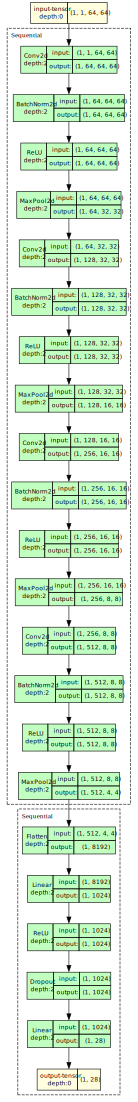

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

import torch
import torch.nn as nn
from torchview import draw_graph

class ArSLModel(nn.Module):
    def __init__(self, num_classes=28):
        super(ArSLModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2), 
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2), 
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2)  
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3),  # instead of 0.5 ----> under fitting
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ArSLModel(num_classes=28).to(device)

input_size = (1, 1, 64, 64) 
model_graph = draw_graph(
    model, 
    input_size=input_size,
    expand_nested=True,
    graph_name='ArSLModel_Enhanced',
    depth=2 
)

model_graph.visual_graph





# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# import torch
# import torch.nn as nn
# from torchview import draw_graph

# class ArSLModel(nn.Module):
#     def __init__(self, num_classes=28):
#         super(ArSLModel, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2), # كانت 32
#             nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), # كانت 64
            
#             nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2), 
#             nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, 2)  
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512 * 4 * 4, 1024), 
#             nn.ReLU(),
#             nn.Dropout(0.3), 
#             nn.Linear(1024, num_classes)
#         )

#     def forward(self, x):
#         return self.classifier(self.features(x))

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = ArSLModel(num_classes=28).to(device)

# input_size = (1, 1, 64, 64) 
# model_graph = draw_graph(
#     model, 
#     input_size=input_size,
#     expand_nested=True,
#     graph_name='ArSLModel_Enhanced',
#     depth=2 
# )

# model_graph.visual_graph

In [38]:
# أولاً تأكدي من تثبيت المكتبة إذا لم تكن موجودة
# !pip install torchinfo

from torchinfo import summary

# رسم الجدول بشكل منظم
model_stats = summary(
    model, 
    input_size=(1, 1, 64, 64), # (Batch_size, Channels, Height, Width)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    col_width=20,
    row_settings=["var_names"]
)

print(model_stats)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds
ArSLModel (ArSLModel)                    [1, 1, 64, 64]       [1, 28]              --                   --                   --
├─Sequential (features)                  [1, 1, 64, 64]       [1, 512, 4, 4]       --                   --                   --
│    └─Conv2d (0)                        [1, 1, 64, 64]       [1, 64, 64, 64]      640                  [3, 3]               2,621,440
│    └─BatchNorm2d (1)                   [1, 64, 64, 64]      [1, 64, 64, 64]      128                  --                   128
│    └─ReLU (2)                          [1, 64, 64, 64]      [1, 64, 64, 64]      --                   --                   --
│    └─MaxPool2d (3)                     [1, 64, 64, 64]      [1, 64, 32, 32]      --                   2                    --
│    └─Conv2d (4)                        [1, 64, 32, 32]      [1, 128, 32, 32]     73,856

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def run_training(epochs=50): 
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    
    early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth')
    
    for epoch in range(epochs):
        model.train()
        t_loss, t_correct, t_total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            _, pred = out.max(1)
            t_total += labels.size(0)
            t_correct += pred.eq(labels).sum().item()
            
        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                v_loss += loss.item()
                _, pred = out.max(1)
                v_total += labels.size(0)
                v_correct += pred.eq(labels).sum().item()
        
        epoch_val_loss = v_loss / len(val_loader)
        history['train_acc'].append(100. * t_correct / t_total)
        history['train_loss'].append(t_loss / len(train_loader))
        history['val_acc'].append(100. * v_correct / v_total)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}: Train {history['train_acc'][-1]:.2f}% | Val {history['val_acc'][-1]:.2f}%")
        
        early_stopping(epoch_val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered. Training stopped.")
            model.load_state_dict(torch.load('best_model.pth'))
            break
            
    return history

history = run_training(epochs=50)

Epoch 1: Train 6.82% | Val 10.11%
Validation loss decreased (inf --> 3.133637).  Saving model ...
Epoch 2: Train 15.39% | Val 17.24%
Validation loss decreased (3.133637 --> 2.896923).  Saving model ...
Epoch 3: Train 38.53% | Val 56.90%
Validation loss decreased (2.896923 --> 1.172516).  Saving model ...
Epoch 4: Train 56.98% | Val 79.31%
Validation loss decreased (1.172516 --> 0.648276).  Saving model ...
Epoch 5: Train 66.09% | Val 83.68%
Validation loss decreased (0.648276 --> 0.463254).  Saving model ...
Epoch 6: Train 71.60% | Val 84.83%
Validation loss decreased (0.463254 --> 0.429385).  Saving model ...
Epoch 7: Train 76.48% | Val 85.29%
Validation loss decreased (0.429385 --> 0.354919).  Saving model ...
Epoch 8: Train 79.06% | Val 90.46%
Validation loss decreased (0.354919 --> 0.285066).  Saving model ...
Epoch 9: Train 82.03% | Val 88.16%
EarlyStopping counter: 1 out of 5
Epoch 10: Train 83.08% | Val 92.30%
Validation loss decreased (0.285066 --> 0.208745).  Saving model ...


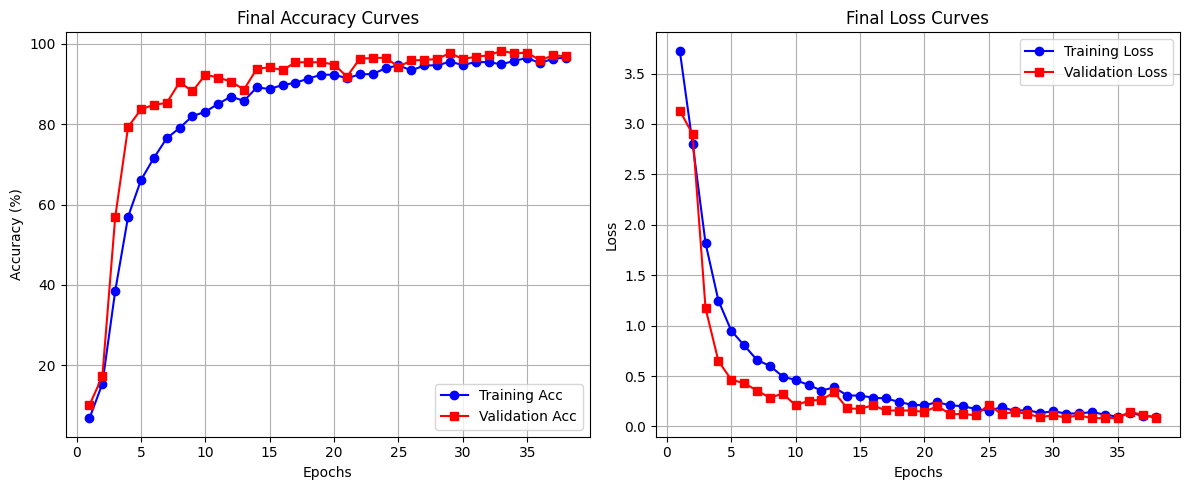

In [7]:
import matplotlib.pyplot as plt

def plot_final_results(history):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 5))
    
    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-s', label='Validation Acc')
    plt.title('Final Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss')
    plt.title('Final Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_final_results(history)

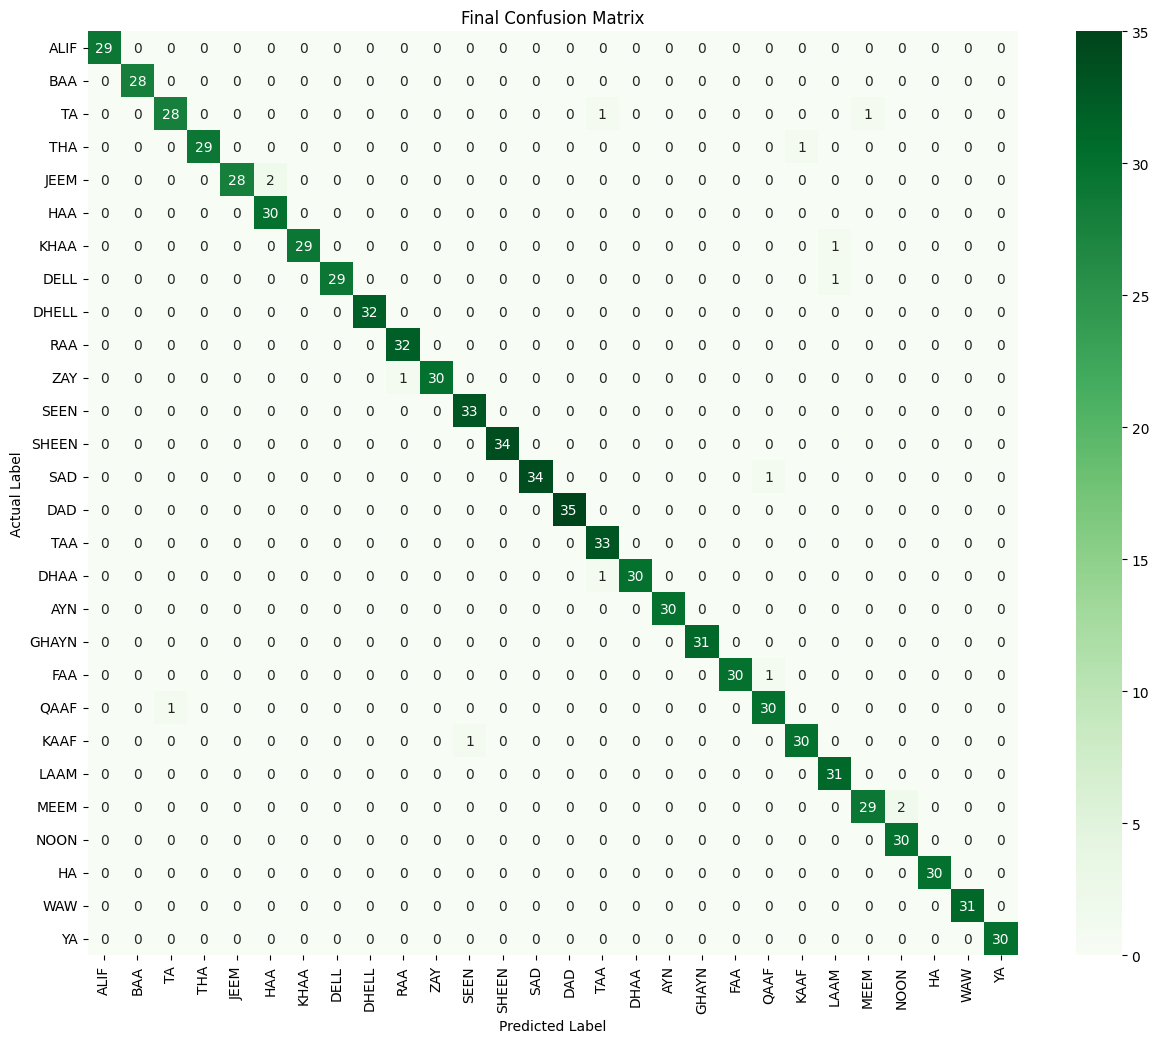


Detailed Classification Report:

              precision    recall  f1-score   support

        ALIF       1.00      1.00      1.00        29
         BAA       1.00      1.00      1.00        28
          TA       0.97      0.93      0.95        30
         THA       1.00      0.97      0.98        30
        JEEM       1.00      0.93      0.97        30
         HAA       0.94      1.00      0.97        30
        KHAA       1.00      0.97      0.98        30
        DELL       1.00      0.97      0.98        30
       DHELL       1.00      1.00      1.00        32
         RAA       0.97      1.00      0.98        32
         ZAY       1.00      0.97      0.98        31
        SEEN       0.97      1.00      0.99        33
       SHEEN       1.00      1.00      1.00        34
         SAD       1.00      0.97      0.99        35
         DAD       1.00      1.00      1.00        35
         TAA       0.94      1.00      0.97        33
        DHAA       1.00      0.97      0.98    

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def final_evaluation(model, loader, classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model(imgs.to(device))
            _, predicted = outputs.max(1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Confusion Matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
    plt.title('Final Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed Report (Precision, Recall, F1)
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))

classes = ['ALIF', 'BAA', 'TA', 'THA', 'JEEM', 'HAA', 'KHAA', 'DELL', 'DHELL', 'RAA', 'ZAY', 'SEEN', 'SHEEN', 'SAD', 'DAD', 'TAA', 'DHAA', 'AYN', 'GHAYN', 'FAA', 'QAAF', 'KAAF', 'LAAM', 'MEEM', 'NOON', 'HA', 'WAW', 'YA']
final_evaluation(model, val_loader, classes)

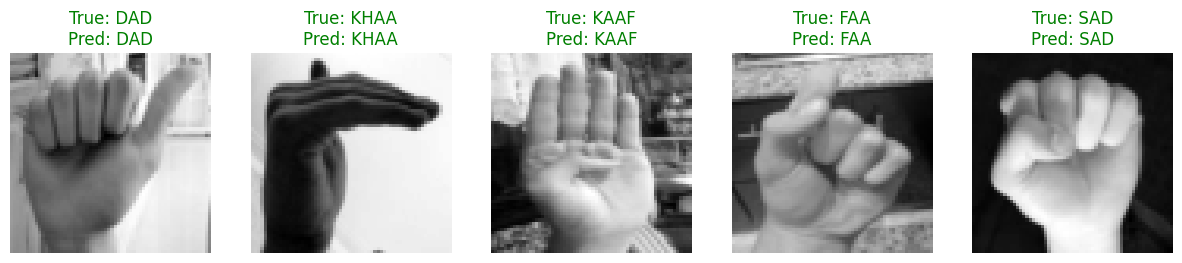

In [9]:
def show_sample_predictions(model, dataset, classes, num=5):
    model.eval()
    plt.figure(figsize=(15, 4))
    for i in range(num):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        
        with torch.no_grad():
            out = model(img.unsqueeze(0).to(device))
            _, pred = out.max(1)
            
        plt.subplot(1, num, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        color = 'green' if pred.item() == label else 'red'
        plt.title(f"True: {classes[label]}\nPred: {classes[pred.item()]}", color=color)
        plt.axis('off')
    plt.show()

show_sample_predictions(model, val_set, classes)

C:\Users\L O Q\AppData\Local\Temp\ipykernel_21804\800829351.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


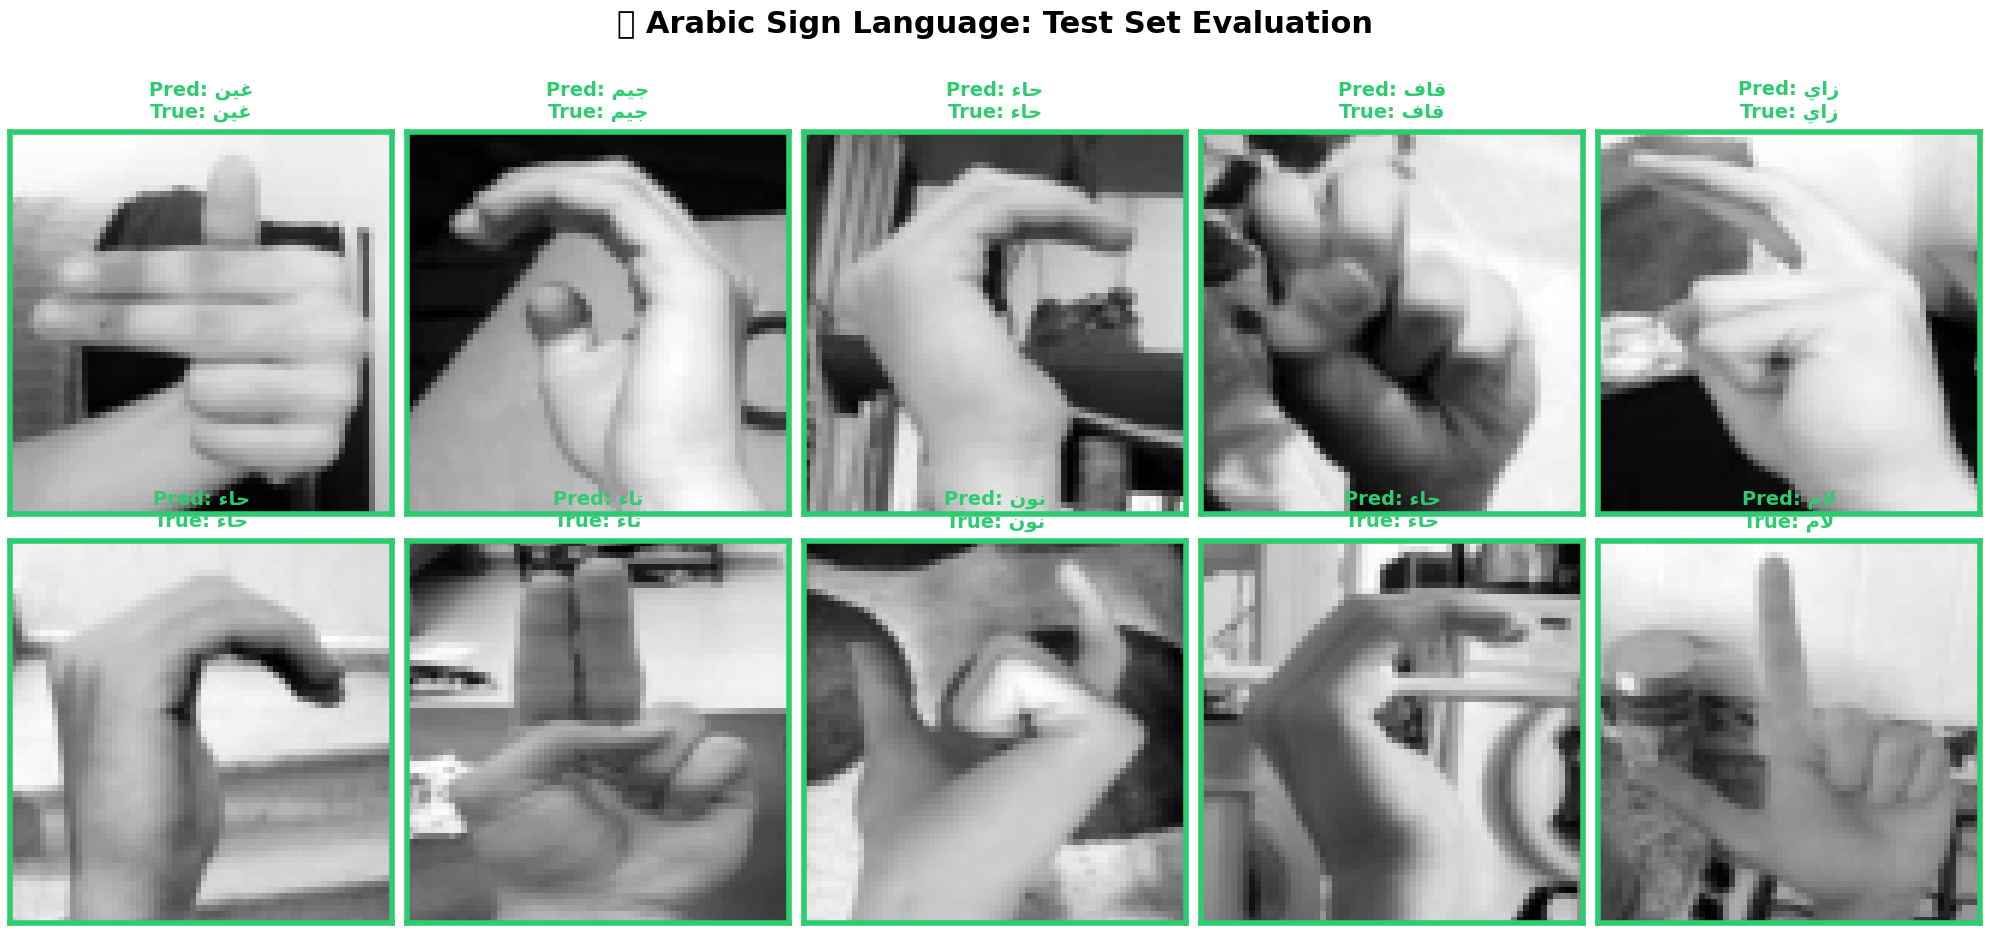

In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import arabic_reshaper
from bidi.algorithm import get_display

def display_styled_results(model, dataset, classes, num_images=10):
    model.eval()
    
    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    fig.suptitle('📊 Arabic Sign Language: Test Set Evaluation', fontsize=22, fontweight='bold', y=0.98)

    indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        with torch.no_grad():
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, predicted = torch.max(output, 1)
            pred_idx = predicted.item()

        true_text = get_display(arabic_reshaper.reshape(classes[label]))
        pred_text = get_display(arabic_reshaper.reshape(classes[pred_idx]))
        
        is_correct = pred_idx == label
        color = '#2ecc71' if is_correct else '#e74c3c'  

        ax = axes[i // cols, i % cols]
        
        img_np = image.squeeze().cpu().numpy()
        ax.imshow(img_np, cmap='gray')
        
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(4)

        ax.set_title(f"Pred: {pred_text}\nTrue: {true_text}", 
                     color=color, fontsize=14, fontweight='bold', pad=10)
        
        ax.axis('on') 
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_styled_results(model, test_set, classes, num_images=10)

In [10]:
torch.save(model.state_dict(), 'model')
print("Model Saved Successfully!")

Model Saved Successfully!


In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       1.00      0.70      0.82        10
           4       0.86      0.60      0.71        10
           5       0.69      0.90      0.78        10
           6       1.00      1.00      1.00        10
           7       0.90      0.90      0.90        10
           8       0.83      0.91      0.87        11
           9       1.00      1.00      1.00        11
          10       1.00      0.90      0.95        10
          11       1.00      1.00      1.00        11
          12       1.00      0.91      0.95        11
          13       1.00      0.92      0.96        12
          14       1.00      1.00      1.00        12
          15       1.00      0.91      0.95        11
          16       0.91      1.00      0.95        10
          17       1.00    

In [11]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import arabic_reshaper
from bidi.algorithm import get_display

model = ArSLModel(num_classes=28) 
model.load_state_dict(torch.load('best_model.pth')) 
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

classes = ['ألف', 'باء', 'تاء', 'ثاء', 'جيم', 'حاء', 'خاء', 'دال', 'ذال', 'راء', 'زاي', 'سين', 'شين', 'صاد', 'ضاد', 'طاء', 'ظاء', 'عين', 'غين', 'فاء', 'قاف', 'كاف', 'لام', 'ميم', 'نون', 'هاء', 'واو', 'ياء']

def draw_arabic_text(img, text, position, font_path='arial.ttf'):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)
    
    font = ImageFont.truetype("arial.ttf", 40) 
    
    draw.text(position, bidi_text, font=font, fill=(0, 255, 0))
    
    return np.array(img_pil)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret: break

    cv2.rectangle(frame, (100, 100), (350, 350), (255, 0, 0), 2)
    roi = frame[100:350, 100:350] 
    
    img_pil = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    img_tensor = data_transforms(img_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = outputs.max(1)
        char_pred = classes[predicted.item()]

    frame = draw_arabic_text(frame, f"التوقع: {char_pred}", (100, 40))
    
    cv2.imshow('Arabic Sign Language Real-time', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

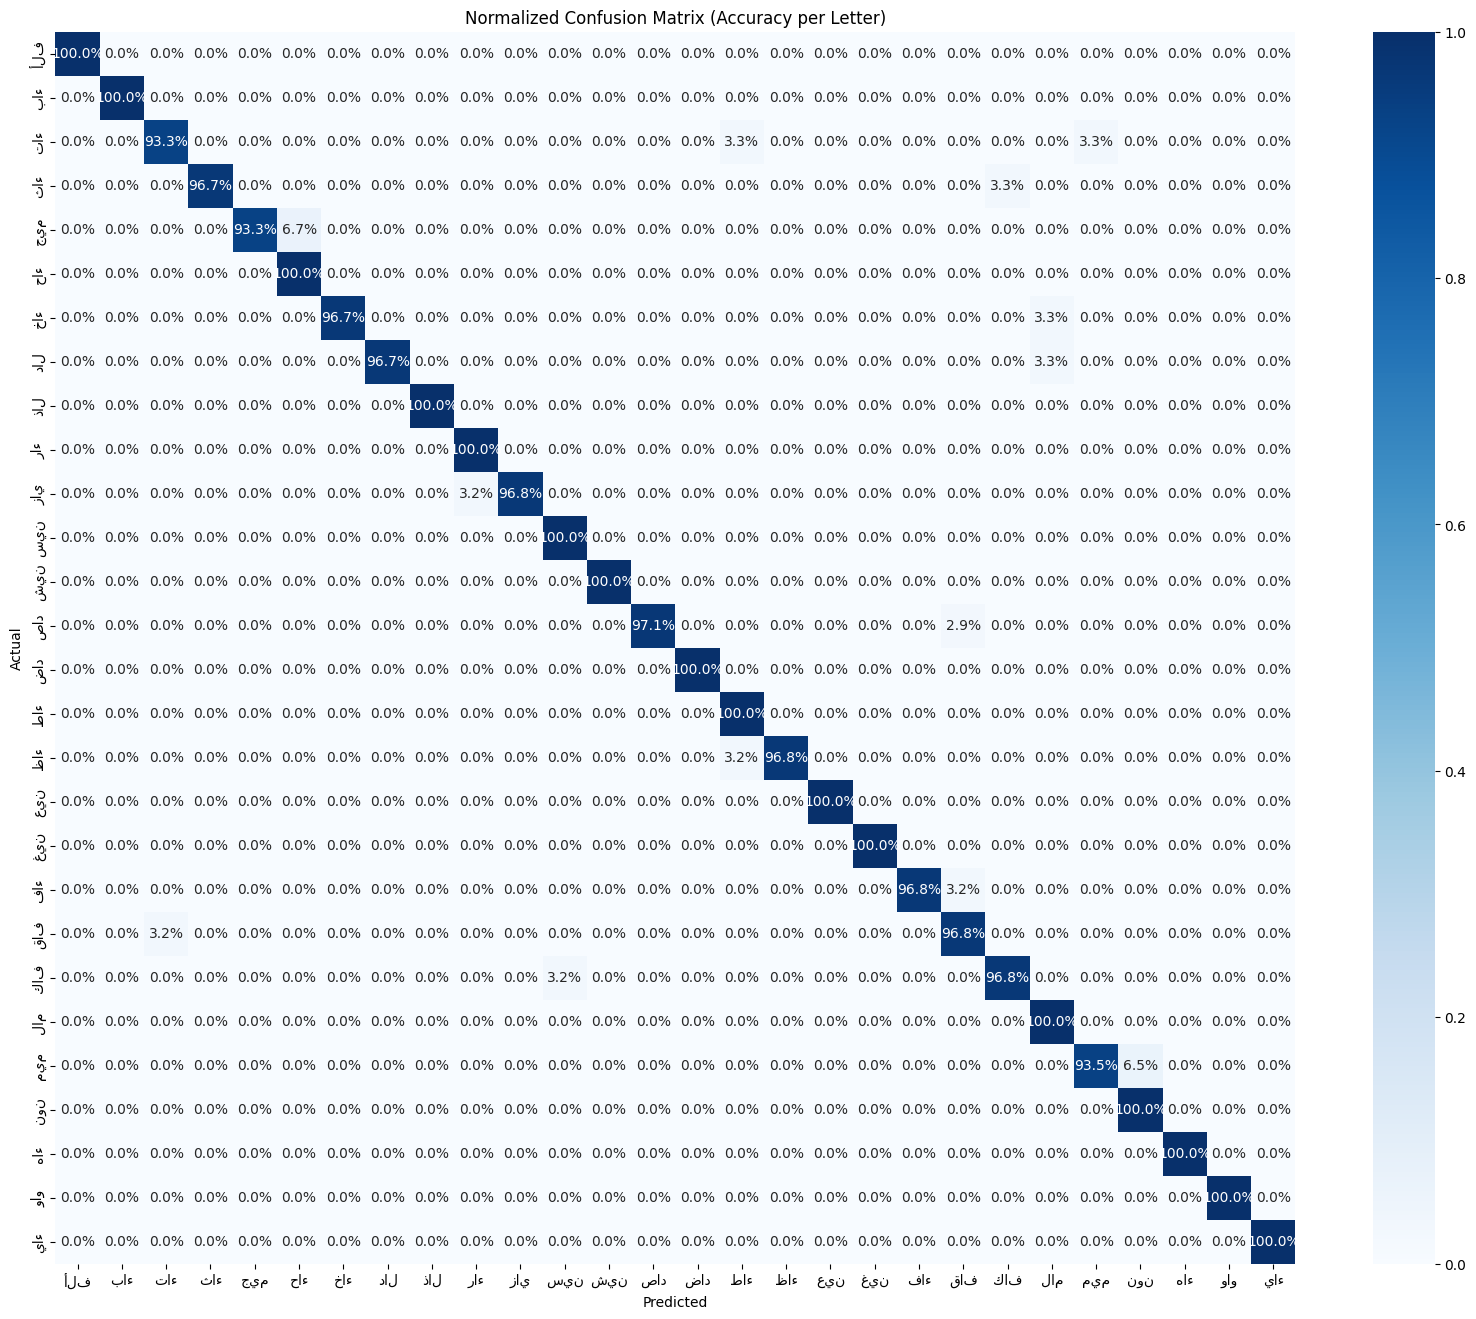

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_advanced_confusion_matrix(model, loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 16))
    sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix (Accuracy per Letter)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_advanced_confusion_matrix(model, val_loader, classes)

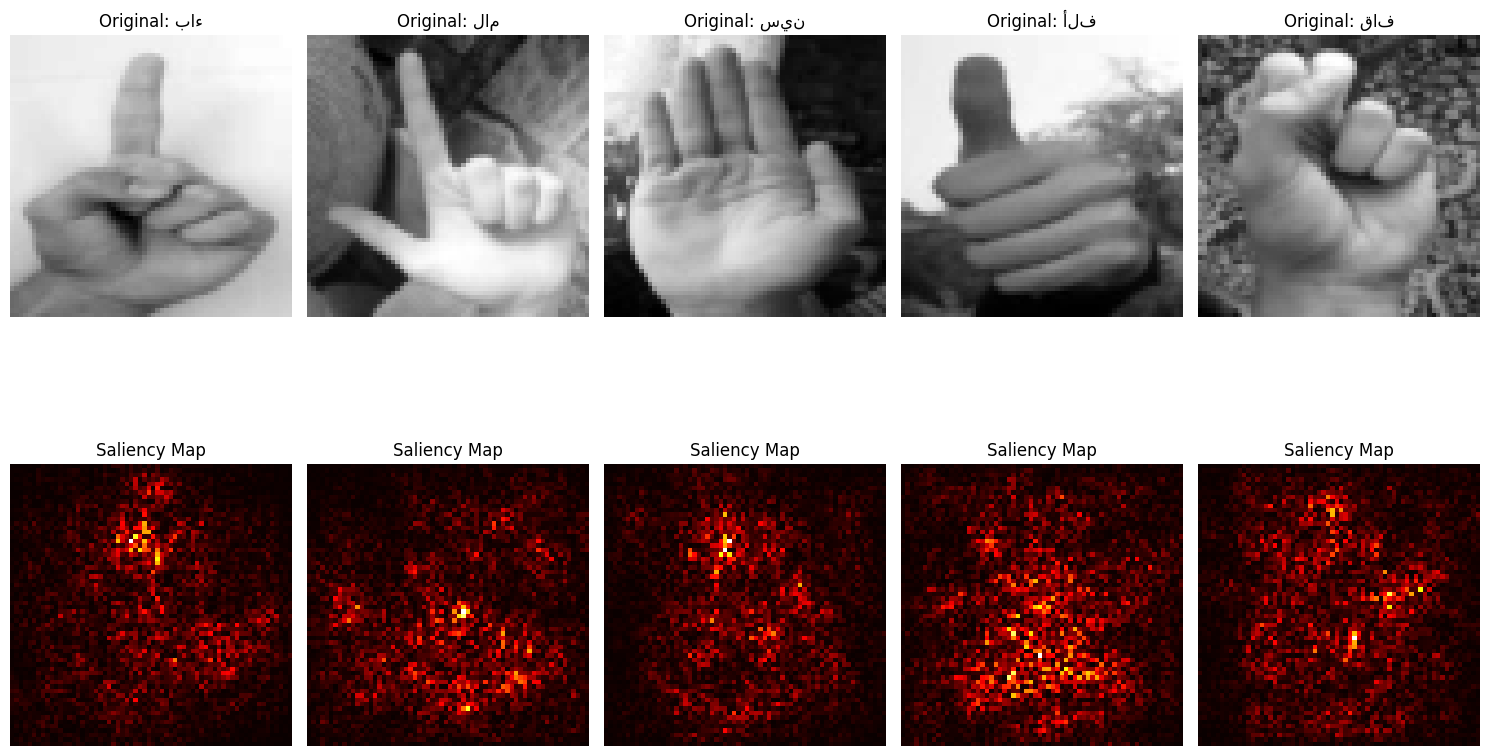

In [13]:
def show_saliency_maps(model, dataset, classes, num_images=5):
    model.eval()
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img = img.unsqueeze(0).to(device)
        img.requires_grad_() 

        output = model(img)
        output_idx = output.argmax()
        output_max = output[0, output_idx]

        output_max.backward()

    
        saliency, _ = torch.max(img.grad.data.abs(), dim=1)
        saliency = saliency.reshape(64, 64)

      
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img.detach().cpu().squeeze(), cmap='gray')
        plt.title(f"Original: {classes[label]}")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(saliency.cpu(), cmap='hot')
        plt.title("Saliency Map")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_saliency_maps(model, val_set, classes)

In [14]:
import torch.onnx
model.eval()

dummy_input = torch.randn(1, 1, 64, 64).to(device)

onnx_path = "sign_language_model.onnx"

# 4. Export the model
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_path, 
    verbose=True, 
    input_names=['input'], 
    output_names=['output'],
    opset_version=11
)

print(f"Model successfully exported to ONNX: {onnx_path}")

W1222 18:41:01.754000 21804 site-packages\torch\onnx\_internal\exporter\_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ArSLModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ArSLModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).
Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "c:\Users\L O Q\AppData\Local\Programs\Python\Python313\Lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
        func=_partial_convert_version, model=model
    )
  File "c:\Users\L O Q\AppData\Local\Programs\Python\Python313\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "c:\Users\L O Q\AppData\Local\Programs\Python\Python313\Lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
Model successfully exported to ONNX: sign_language_model.onnx


In [15]:
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

try:
    # Loading the test dataset
    test_set = ArabicSignDataset('Data Set/test', transform=test_transform)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    print(f"Loaded {len(test_set)} images for testing.")
except FileNotFoundError:
    print("Error: 'Data Set/test' folder not found. Check the path.")

def get_test_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run accuracy check
if 'model' in locals() and 'test_loader' in locals():
    try:
        model.load_state_dict(torch.load('best_model.pth', map_location=device))
        accuracy = get_test_accuracy(model, test_loader)
        print(f"Test Accuracy: {accuracy:.2f}%")
    except FileNotFoundError:
        print("Error: Saved model file (model.pth) not found.")

Loaded 290 images for testing.
Test Accuracy: 94.14%


In [16]:
test_acc = get_test_accuracy(model, val_loader)
print(f"Final Accuracy: {test_acc:.2f}%")

Final Accuracy: 98.28%


In [21]:
from torchsummary import summary
summary(model, input_size=(1, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-14            [-1, 51